In [1]:
import zeus21
from matplotlib import pyplot as plt
from matplotlib import colors as cc 
import numpy as np
import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib.cm import get_cmap
from scipy.interpolate import interp1d
from mpl_toolkits.axes_grid1 import make_axes_locatable

import warnings 
warnings.filterwarnings("ignore")

from zeus21 import LIM

#set up the CLASS cosmology
from classy import Class
ClassCosmo = Class()
ClassCosmo.compute()

In [2]:
plt.rcParams.update({"text.usetex": True, "font.family": "Times new roman"}) # Use latex fonts
plt.rcParams['lines.linewidth'] = 2
colors = ['#001219', '#005f73', '#0a9396', '#94d2bd', '#e9d8a6', '#ee9b00', '#ca6702', '#bb3e03', '#ae2012', '#9b2226']
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors) # Set the color palette as default

In [3]:
def Interpolation_SFRD_delta(z0, R0, LineParams, AstroParams, HMFintclass, CosmoParams, use_interpolation, input_delta_array, input_sigmaR):

    if use_interpolation:
        sigmaR = HMFintclass.sigmaRintlog((np.log(R0), z0))

        Nsigmad = 2.0 #how many sigmas we explore
        Nds = 1001 #how many deltas

        # Create a log-spaced array for positive values
        pos = np.logspace(-10, np.log10(Nsigmad), int(Nds/2))  
        neg = -pos[::-1]  # Mirror for negative side
        # Combine negative and positive parts
        deltatab_norm = np.concatenate((neg, pos))

        deltaArray = deltatab_norm * sigmaR
    
    else:
        deltaArray = input_delta_array * input_sigmaR
        sigmaR = input_sigmaR
    
    mArray, deltaArray_Mh = np.meshgrid(HMFintclass.Mhtab, deltaArray, indexing = 'ij', sparse = True)

    sigmaM = HMFintclass.sigmaintlog((np.log(mArray),z0))

    modSigmaSq = sigmaM**2 - sigmaR**2
    indexTooBig = (modSigmaSq <= 0.0)
    modSigmaSq[indexTooBig] = np.inf #if sigmaR > sigmaM the halo does not fit in the radius R. Cut the sum
    modSigma = np.sqrt(modSigmaSq)

    nu0 = CosmoParams.delta_crit_ST / sigmaM
    nu0[indexTooBig] = 1.0
    modd = CosmoParams.delta_crit_ST - deltaArray_Mh
    nu = modd / modSigma

    EPS_HMF_corr = (nu/nu0) * (sigmaM/modSigma)**2.0 * np.exp(-CosmoParams.a_corr_EPS * (nu**2-nu0**2)/2.0 ) * (1.0 + deltaArray_Mh)

    HMF_curr = np.exp(HMFintclass.logHMFint((np.log(mArray),z0)))
    SFRtab_currII = zeus21.sfrd.SFR_II(AstroParams, CosmoParams, HMFintclass, mArray, z0, 0.)

    integrand = EPS_HMF_corr *  HMF_curr * SFRtab_currII * HMFintclass.Mhtab[:,np.newaxis]

    integrand_LIM = EPS_HMF_corr *  HMF_curr * LIM.LineLuminosity(SFRtab_currII, LineParams, AstroParams, CosmoParams, HMFintclass, mArray, z0)  * HMFintclass.Mhtab[:,np.newaxis]

    SFRDbox_flattend = np.trapezoid(integrand, HMFintclass.logtabMh, axis = 0) 

    Lbox_flattened = np.trapezoid(integrand_LIM,HMFintclass.logtabMh, axis = 0)

    if use_interpolation:

        interpolate_funct = interp1d(deltaArray, SFRDbox_flattend, kind='cubic',bounds_error=True)

        SFRDbox_flattend = interpolate_funct(input_delta_array * input_sigmaR)

        interpolate_LIM_funct = interp1d(deltaArray, Lbox_flattened, kind='linear',bounds_error=True)

        Lbox_flattened = interpolate_LIM_funct(input_delta_array * input_sigmaR)


    return SFRDbox_flattend, Lbox_flattened

In [4]:
def LIM_boxes(z0, Lbox, Nbox, delta_box, LineParams, AstroParams, HMFintclass, CosmoParams, use_interpolation):
    
    variance = np.var(delta_box)
    sigmaR = np.sqrt(variance)

    R0 = Lbox / Nbox
    SFRDbox_flattend, Lbox_flattend = Interpolation_SFRD_delta(z0, R0, LineParams, AstroParams, HMFintclass, CosmoParams, use_interpolation, delta_box.flatten(), sigmaR)

    delta_box_sigmaR = delta_box * sigmaR
    SFRD_box = SFRDbox_flattend.reshape(Nbox,Nbox,Nbox)
    L_box = Lbox_flattend.reshape(Nbox,Nbox,Nbox)

    if LineParams.LINE == 'CO':
        nu_line_rest = -1
    elif LineParams.LINE == 'CII':
        nu_line_rest = LineParams.CII_nu_rest
    else:
        nu_line_rest = -1

    if LineParams.OBSERVABLE_LIM == 'Tnu':

        # c1 = uK / Lsun * Mpc^3
        coeff1_LIM = (((zeus21.constants.c_kms * LIM.au.km/LIM.au.s)**3 * (1+z0)**2 / (8*np.pi * (zeus21.cosmology.Hub(CosmoParams, z0) * LIM.au.km/LIM.au.s/LIM.au.Mpc) * (nu_line_rest * LIM.au.Hz)**3 * LIM.ac.k_B)).to(LIM.au.uK * LIM.au.Mpc**3 / LIM.au.Lsun )).value

        # c2 = Lbar = Lsun / Mpc^3 
        coeff2_LIM = 1.

        # --> c1*c2 = uK

    elif LineParams.OBSERVABLE_LIM == 'Inu':

        # nu_rest for CII is in Hz, speed of light in km / s , Hubble in km / s / Mpc --> c1 = cm / sr / Hz
        coeff1_LIM = ((zeus21.constants.c_kms * LIM.au.km/LIM.au.s) / (4*np.pi * (zeus21.cosmology.Hub(CosmoParams, z0) * LIM.au.km/LIM.au.s/LIM.au.Mpc) * nu_line_rest * LIM.au.Hz)) * zeus21.constants.Mpctocm

        # c2 = Lbar = Lsun / Mpc^3 
        coeff2_LIM = 1. / zeus21.constants.Mpctocm**3

    Inu_box = L_box * coeff1_LIM * coeff2_LIM 

    return delta_box_sigmaR, SFRD_box, L_box, Inu_box

In [5]:
def produce_boxes(z, Lbox, Nbox, box_density, box_SFRD, box_21cm, box_ionization, box_rhoL, box_LIM, smooth, RSDMODE, CosmoParams_input, AstroParams_input, LineParams_input, ZMIN, _islice, seed, fig, ax):
    
    if smooth:
        print('Smoothing not yet implemented!')
        return 

    all_boxes = [box_density, box_SFRD, box_21cm, box_ionization, box_rhoL, box_LIM]
    box_slices = []
    vmin = []
    vmax = []
    cmap = []
    title = []

    how_many_boxes = sum(all_boxes)
    if how_many_boxes != 3:
        print('For now we only implemented 3 boxes plot!')
        return 

    CosmoParams, ClassyCosmo, CorrFclass_zeus, HMFclass =  zeus21.cosmo_wrapper(CosmoParams_input)

    AstroParams = zeus21.Astro_Parameters(CosmoParams, **AstroParams_input)

    LineParams = zeus21.Line_Parameters(LineParams_input)

    run_sfrd_module = zeus21.get_T21_coefficients(CosmoParams, ClassyCosmo, AstroParams, HMFclass, zmin=ZMIN)

    PS_zeus = zeus21.Power_Spectra(CosmoParams, AstroParams, ClassyCosmo, CorrFclass_zeus, run_sfrd_module, RSD_MODE = RSDMODE)

    #run_LIM_module = zeus21.get_LIM_coefficients(CosmoParams, AstroParams, HMFclass, LineParams, zmin=ZMIN)

    Map_zeus21 = zeus21.CoevalMaps(run_sfrd_module, PS_zeus, z, KIND=1,Lbox=Lbox,Nbox=Nbox,seed=seed)

    delta_box = Map_zeus21.deltamap
    coeval_slice_density = delta_box[_islice]
    if box_density:
        box_slices.append(coeval_slice_density)
        cmap.append('magma')
        title.append(r'$\delta,\,z = %g$'%round(z,1))
        vmin.append(-0.6)
        vmax.append(0.6)

    if box_21cm or box_ionization:

        BMF = zeus21.BMF(run_sfrd_module, HMFclass,CosmoParams,AstroParams)

        coeval_slice_ion = zeus21.maps.make_ion_fields(CosmoParams, run_sfrd_module, ClassyCosmo, CorrFclass_zeus, BMF, z, boxlength=Lbox, ncells=Nbox, seed=seed, r_precision=1., timer=False, logd = False, barrier = None, spherize=False, FLAG_return_densities = 0)[0][0][_islice]

        if box_21cm:
            coeval_slice_T21 = Map_zeus21.T21map[_islice]
            coeval_slice_T21 = (1.-coeval_slice_ion) * coeval_slice_T21

            box_slices.append(coeval_slice_T21)

            min_value = np.min(coeval_slice_T21)
            max_value = np.max(coeval_slice_T21)

            # There are zero values! We'll have blue for negative temperatures and red for positive ones
            if min_value < 0 and max_value > 0:
                mid_point = abs(min_value)/(abs(min_value)+abs(max_value))
                colors_list = [(0, 'cyan'),
                                (mid_point/2., 'blue'),
                                (mid_point, "black"),
                                ((1.+mid_point)/2., 'red'),
                                (1, 'yellow')]
            # All values are negative! We'll have only blue colors
            elif max_value < 0:
                colors_list = [(0, 'cyan'),
                                (0.5, 'blue'),
                                (1, "black")]
            # All values are positive! We'll have only red colors
            else:
                colors_list = [(0, "black"),
                                (0.5, 'red'),
                                (1., 'yellow')]
            eor_colour = cc.LinearSegmentedColormap.from_list("eor_colour",colors_list)

            cmap.append(eor_colour)
            title.append(r'$T_{21}\,[\mu {\rm K}],\,z = %g$'%round(z,1))
            vmin.append(min_value)
            vmax.append(max_value)

        if box_ionization:
            box_slices.append(coeval_slice_ion)
            cmap.append('grey')
            title.append(r'$\rm Ionization\,field,\,z = %g$'%round(z,1))
            vmin.append(None)
            vmax.append(None)

    if box_SFRD or box_rhoL or box_LIM:

        temp = LIM_boxes(z, Lbox, Nbox, delta_box, LineParams, AstroParams, HMFclass, CosmoParams, use_interpolation = False)

        if box_SFRD:
            SFRD_box = temp[1]
            coeval_slice_SFRD = SFRD_box[_islice]
            box_slices.append(coeval_slice_SFRD)
            cmap.append('bwr')
            title.append(r'${\rm SFRD}\,[M_\odot/{\rm yr}],\,z = %g$'%round(z,1))
            vmin.append(None)
            vmax.append(None)

        if box_rhoL:
            rhoL_box = temp[2]
            coeval_slice_rhoL = rhoL_box[_islice]
            box_slices.append(coeval_slice_rhoL)
            cmap.append(get_cmap('GnBu_r'))
            title.append(r'$\rho_L\,[L_\odot/{\rm Mpc}^3],\,z = %g$'%round(z,1))
            vmin.append(None)
            vmax.append(None)

        if box_LIM:
            LIM_box = temp[3]
            coeval_slice_LIM = LIM_box[_islice]
            box_slices.append(coeval_slice_LIM)

            summer_cmap = cm.summer
            colors_list = [(0, "black"),
               (0.1, summer_cmap(0)),    
               (0.2, summer_cmap(50)),
               (0.5, summer_cmap(150)),
               (1, summer_cmap(255))]     
            
            LIM_colour = cc.LinearSegmentedColormap.from_list("LIM_colour",colors_list)

            min_value = np.min(coeval_slice_LIM)
            max_value = np.max(coeval_slice_LIM)

            cmap.append(LIM_colour)
            title.append(r'$T_\nu\,[\mu{\rm K}],\,z = %g$'%round(z,1))
            vmin.append(1e-8)
            vmax.append(1e-1)

    if not fig and not ax:
        fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(7,3))
    
    for i in range(len(box_slices)):

        im = ax[i].imshow(box_slices[i],extent=(0,Lbox,0,Lbox),cmap=cmap[i],vmax =vmax[i], vmin = vmin[i]) 

        colorbars[i] =  fig.colorbar(im, ax=ax[i], fraction=0.046, pad=0.04, format="%.0e")
        
        ax[i].set_title(title[i])
        ax[i].set_xticks([])
        ax[i].set_yticks([])

    fig.tight_layout()
    #plt.show()

    return fig

In [6]:
CosmoParams_input = zeus21.Cosmo_Parameters_Input()

In [7]:
LineParams_input = zeus21.LineParams_Input(\
                 LINE = 'CII',
                 OBSERVABLE_LIM = 'Tnu',
                 _R = 2,  
                 CII_MODEL = 'Lagache18',
                 CII_nu_rest = 1.897e12, 
                 CII_alpha_SFR_0 = 1.4-0.07*10,
                 CII_alpha_SFR_z = 0.,
                 CII_beta_SFR_0 = 7.1-0.07*10,
                 CII_beta_SFR_z = 0.,
                 CII_sigma_LSFR = 0.)

In [38]:
zmin = 6.5
zmax = 25.
Npt_z = 3

zvals = np.linspace(zmax,zmin,Npt_z)
zvals = [12.]

100%|██████████| 1/1 [00:00<00:00, 26.42it/s]


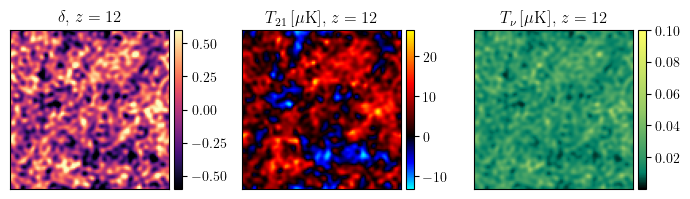

In [40]:
for zi in zvals:
    produce_boxes(z = zi, Lbox = 100, Nbox = 100, box_density = True, box_SFRD = False, box_21cm = True, box_ionization = False, box_rhoL = False, box_LIM = True, smooth = False, RSDMODE = 0, CosmoParams_input = CosmoParams_input, AstroParams_input = {}, LineParams_input = LineParams_input, ZMIN = 5., _islice = 0, seed = 1605, fig=False,ax=False)

In [6]:
import matplotlib.animation as animation
from IPython.display import HTML
plt.rcParams['animation.embed_limit'] = 100  # Set the embed limit to 100 MB

In [7]:
def get_box_slices(z, Lbox, Nbox, RSDMODE, CosmoParams_input, AstroParams_input, LineParams_input, ZMIN, _islice, seed):

    box_slices = []
    vmin = []
    vmax = []
    cmap = []
    title = []

    CosmoParams, ClassyCosmo, CorrFclass_zeus, HMFclass =  zeus21.cosmo_wrapper(CosmoParams_input)

    AstroParams = zeus21.Astro_Parameters(CosmoParams, **AstroParams_input)

    LineParams = zeus21.Line_Parameters(LineParams_input)

    run_sfrd_module = zeus21.get_T21_coefficients(CosmoParams, ClassyCosmo, AstroParams, HMFclass, zmin=ZMIN)

    PS_zeus = zeus21.Power_Spectra(CosmoParams, AstroParams, ClassyCosmo, CorrFclass_zeus, run_sfrd_module, RSD_MODE = RSDMODE)

    #run_LIM_module = zeus21.get_LIM_coefficients(CosmoParams, AstroParams, HMFclass, LineParams, zmin=ZMIN)

    Map_zeus21 = zeus21.CoevalMaps(run_sfrd_module, PS_zeus, z, KIND=1,Lbox=Lbox,Nbox=Nbox,seed=seed)

    delta_box = Map_zeus21.deltamap
    coeval_slice_density = delta_box[_islice]

    box_slices.append(coeval_slice_density)
    cmap.append('magma')
    title.append(r'$\delta,\,z = %g$'%round(z,1))
    vmin.append(-0.6)
    vmax.append(0.6)


    BMF = zeus21.BMF(run_sfrd_module, HMFclass,CosmoParams,AstroParams)

    coeval_slice_ion = zeus21.maps.make_ion_fields(CosmoParams, run_sfrd_module, ClassyCosmo, CorrFclass_zeus, BMF, z, boxlength=Lbox, ncells=Nbox, seed=seed, r_precision=1., timer=False, logd = False, barrier = None, spherize=False, FLAG_return_densities = 0)[0][0][_islice]

    coeval_slice_T21 = Map_zeus21.T21map[_islice]
    coeval_slice_T21 = (1.-coeval_slice_ion) * coeval_slice_T21

    box_slices.append(coeval_slice_T21)

    min_value = np.min(coeval_slice_T21)
    max_value = np.max(coeval_slice_T21)

    # There are zero values! We'll have blue for negative temperatures and red for positive ones
    if min_value < 0 and max_value > 0:
        mid_point = abs(min_value)/(abs(min_value)+abs(max_value))
        colors_list = [(0, 'cyan'),
                        (mid_point/2., 'blue'),
                        (mid_point, "black"),
                        ((1.+mid_point)/2., 'red'),
                        (1, 'yellow')]
    # All values are negative! We'll have only blue colors
    elif max_value < 0:
        colors_list = [(0, 'cyan'),
                        (0.5, 'blue'),
                        (1, "black")]
    # All values are positive! We'll have only red colors
    else:
        colors_list = [(0, "black"),
                        (0.5, 'red'),
                        (1., 'yellow')]
    eor_colour = cc.LinearSegmentedColormap.from_list("eor_colour",colors_list)

    cmap.append(eor_colour)
    title.append(r'$T_{21}\,[\mu {\rm K}],\,z = %g$'%round(z,1))
    vmin.append(min_value)
    vmax.append(max_value)


    temp = LIM_boxes(z, Lbox, Nbox, delta_box, LineParams, AstroParams, HMFclass, CosmoParams, use_interpolation = False)

    LIM_box = temp[3]
    coeval_slice_LIM = LIM_box[_islice]
    box_slices.append(coeval_slice_LIM)

    summer_cmap = cm.summer
    colors_list = [(0, "black"),
        (0.1, summer_cmap(0)),    
        (0.2, summer_cmap(50)),
        (0.5, summer_cmap(150)),
        (1, summer_cmap(255))]     
    
    LIM_colour = cc.LinearSegmentedColormap.from_list("LIM_colour",colors_list)

    min_value = np.min(coeval_slice_LIM)
    max_value = np.max(coeval_slice_LIM)

    cmap.append(LIM_colour)
    title.append(r'$T_\nu\,[\mu{\rm K}],\,z = %g$'%round(z,1))
    vmin.append(1e-8)
    vmax.append(1e-1)
    
    return box_slices, cmap, title, vmin, vmax

100%|██████████| 1/1 [00:00<00:00, 18.89it/s]


100%|██████████| 1/1 [00:00<00:00, 18.83it/s]


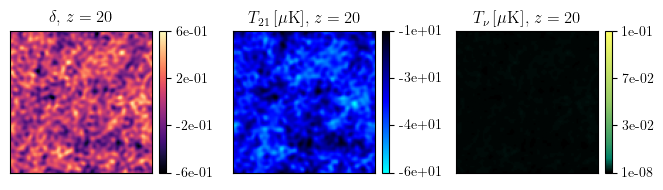

In [32]:
# zmin = 6.5
# zmax = 20.5
# Npt_z = 39
zvals = np.concatenate((np.linspace(20.,15.5,7),np.linspace(15,6.5,35)))

Lbox = 100
Nbox = 100
box_density = True
box_SFRD = False
box_21cm = True
box_ionization = False
box_rhoL = False
box_LIM = True
smooth = False
RSDMODE = 0
CosmoParams_input_use = zeus21.Cosmo_Parameters_Input()
AstroParams_input = {}
LineParams_input_use = zeus21.LineParams_Input(\
                 LINE = 'CII',
                 OBSERVABLE_LIM = 'Tnu',
                 _R = 2,  
                 CII_MODEL = 'Lagache18',
                 CII_nu_rest = 1.897e12, 
                 CII_alpha_SFR_0 = 1.4-0.07*10,
                 CII_alpha_SFR_z = 0.,
                 CII_beta_SFR_0 = 7.1-0.07*10,
                 CII_beta_SFR_z = 0.,
                 CII_sigma_LSFR = 0.)
ZMIN = 5.
_islice = 0
seed = 1605


fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(7, 2))

box_slices, cmap, title, vmin_use, vmax_use = get_box_slices(zvals[0], Lbox, Nbox, RSDMODE, CosmoParams_input_use, AstroParams_input, LineParams_input_use, ZMIN, _islice, seed)

im = []
cbar = []
for j in range(len(box_slices)):

    im.append(ax[j].imshow(box_slices[j],extent=(0,Lbox,0,Lbox),cmap=cmap[j],vmax =vmax_use[j], vmin = vmin_use[j]))
    cbar.append(fig.colorbar(im[j], ax=ax[j], fraction=0.046, pad=0.04, format="%.0e"))


def animate(ff, zvals, Lbox, Nbox, RSDMODE, CosmoParams_input, AstroParams_input, LineParams_input, ZMIN, _islice, seed, im):
        
    zi = zvals[ff]

    box_slices, cmap, title, vmin_use, vmax_use = get_box_slices(zi, Lbox, Nbox, RSDMODE, CosmoParams_input, AstroParams_input, LineParams_input, ZMIN, _islice, seed)
    
    for i in range(len(box_slices)):

        im[i] = ax[i].imshow(box_slices[i],extent=(0,Lbox,0,Lbox),cmap=cmap[i],vmax =vmax_use[i], vmin = vmin_use[i])
        cbar[i].update_normal(im[i])

        xticks = np.linspace(vmin_use[i],vmax_use[i],4)
        array_ticks = np.vectorize(lambda x: f"{x:.0e}")(xticks)
        cbar[i].set_ticks(xticks, labels = array_ticks)
        
        ax[i].set_title(title[i],fontsize=12)
        ax[i].set_xticks([])
        ax[i].set_yticks([])

    fig.tight_layout()

    return fig


ani = animation.FuncAnimation(fig=fig, 
                              func=animate, 
                              frames=len(zvals), 
                              fargs=(zvals, Lbox, Nbox, RSDMODE, CosmoParams_input_use, AstroParams_input, LineParams_input_use, ZMIN, _islice, seed, im), 
                              interval=500)

ani.save('./plots/boxes_test.gif', writer='pillow', fps=1)
HTML(ani.to_jshtml())